# Strain Prediction from Distributed Sensing

Using the data collection from 2023-01-21 (data collection for each sensor repeated sequentially).
Using strain from tensile tester and 4-channel impedance signals recorded with the sensor readout board, predict the four joint angles.
Corresponds to the Section 2 *Localized Strain Reconstruction* from [1].

> [1] Brett C. Hannigan, Tyler J. Cuthbert, Chakaveh Ahmadizadeh, and Carlo Menon. Distributed Sensing Along Fibres for Smart Clothing. *Science Advances*. 2023 (In Review).

©2023 ETH Zurich, Brett Hannigan; D-HEST; Biomedical and Mobile Health Technology (BMHT) Lab; Carlo Menon

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from collections import Counter
from scipy.fft import fft, fftfreq
from scipy import signal
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from keras import Sequential
from keras import regularizers
from keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout, ReLU
from keras.utils import Sequence
from keras.optimizers import Adam, Adagrad
from keras.utils import Sequence
from keras.regularizers import L1, L2, L1L2
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from datetime import datetime
import tensorflow as tf
import random
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Import data
Convert strain label to per-sensor strain array depending on the value of `sensor` for each row of `data`. Create training and testing datasets.

In [2]:
data = pd.read_csv("T:\\Data\\2023-01-21_DistributedSensorTesting\\Synchronized\\Data.csv", index_col=0)
data = data.dropna(axis=0)
data = data.sort_values(by=['trial', 'sensor', 'time'])
iq_data = data.pivot_table(index=['trial', 'sensor', 'time', 'strain'], values=['I', 'Q'], columns='f')
iq_data = iq_data.reset_index(drop=False)
iq_data['strain_A'] = ['A' in x for x in iq_data['sensor']]*iq_data['strain']
iq_data['strain_B'] = ['B' in x for x in iq_data['sensor']]*iq_data['strain']
iq_data['strain_C'] = ['C' in x for x in iq_data['sensor']]*iq_data['strain']
iq_data['strain_D'] = ['D' in x for x in iq_data['sensor']]*iq_data['strain']
iq_data.head()

trial sensor  time    strain          I                                 \
f                                   12451      24902     49805     99609   
0     0      A  0.00  0.000000  61.735968  51.582492 -0.609893  1.306422   
1     0      A  0.01  0.000002  60.924998  51.307946 -0.309325  1.306422   
2     0      A  0.02  0.000004  60.114029  51.032348 -0.007606  1.306422   
3     0      A  0.03  0.000007  59.304094  50.757802  0.292962  1.306422   
4     0      A  0.04  0.000011  58.493124  50.483257  0.593529  1.306422   

          Q                                 strain_A strain_B strain_C  \
f     12451      24902     49805     99609                               
0  9.670989 -14.778372  5.181193 -3.642874  0.000000      0.0      0.0   
1  9.376489 -15.124890  4.230798 -4.183927  0.000002      0.0      0.0   
2  9.070209 -15.471408  3.282219 -4.727053  0.000004      0.0      0.0   
3  8.775709 -15.805092  2.331824 -5.268106  0.000007      0.0      0.0   
4  8.469429 -16.151610  1.383245 -5.809159  0.000011      0.0      0.0   

  strain_D  
f           
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0

## Split into Train, Test, Validation Sets

Apply filter, and split by single/multiple sensor(s) strained simultaneously.

In [3]:
iq_train = iq_data[(iq_data.trial==0) | (iq_data.trial==1) | (iq_data.trial==2) | (iq_data.trial==3)]
iq_val = iq_data[iq_data.trial==4]
iq_test = iq_data[iq_data.trial==5]
x_train = iq_train[['I', 'Q']]
x_val = iq_val[['I', 'Q']]
x_test = iq_test[['I', 'Q']]
x_train = x_train.sort_index(axis=1,level=[0,1],ascending=[True,False]) # Sort by decreasing frequency (to match ReadSensor.py).
x_val = x_val.sort_index(axis=1,level=[0,1],ascending=[True,False]) 
x_test = x_test.sort_index(axis=1,level=[0,1],ascending=[True,False]) 
LPF_CUTOFF = 1 # Hz
T_S = 1/100 # s
b, a = signal.butter(4, LPF_CUTOFF*T_S*2)
x_train = x_train.apply(lambda x: signal.filtfilt(b, a, x), 0)
x_val = x_val.apply(lambda x: signal.filtfilt(b, a, x), 0)
x_test = x_test.apply(lambda x: signal.filtfilt(b, a, x), 0)
ss = StandardScaler()
x_train.iloc[:,:] = ss.fit_transform(x_train.to_numpy())
x_val.iloc[:,:] = ss.transform(x_val.to_numpy())
x_test.iloc[:,:] = ss.transform(x_test.to_numpy())
y_train = iq_train[['strain_A', 'strain_B', 'strain_C', 'strain_D']]
y_val = iq_val[['strain_A', 'strain_B', 'strain_C', 'strain_D']]
y_test = iq_test[['strain_A', 'strain_B', 'strain_C', 'strain_D']]

In [4]:
is_multi = np.zeros((len(iq_data)), dtype=bool)
is_multi = np.logical_or(iq_data['sensor']=='AB', iq_data['sensor']=='BC')
is_multi = np.logical_or(is_multi, iq_data['sensor']=='CD')
is_single = np.logical_not(is_multi)

In [5]:
is_train = np.zeros((len(iq_data)), dtype=bool)
is_val = np.zeros((len(iq_data)), dtype=bool)
is_test = np.zeros((len(iq_data)), dtype=bool)
is_train = (iq_data.trial==0) | (iq_data.trial==1) | (iq_data.trial==2) | (iq_data.trial==3)
is_val = iq_data.trial==4
is_test = iq_data.trial==5

## Scoring Handler Functions

In [6]:
def compute_fit(model, x, y, sensor, scorefn):
    sensor_unique = np.sort(sensor.unique())
    score = {s : 0 for s in sensor_unique}
    for sens in sensor_unique:
        x_sensor = x[sensor.eq(sens)]
        y_sensor = y[sensor.eq(sens)]
        y_pred = model.predict(x_sensor)
        score[sens] = scorefn(y_sensor, y_pred, multioutput='raw_values')
    return score

def compute_fit_all(model, X, Y, sensor, scorefn):
    x = {'train' : X[0], 'test' : X[1], 'all' : pd.concat(X, axis=0)}
    y = {'train' : Y[0], 'test' : Y[1], 'all' : pd.concat(Y, axis=0)}
    score_all = {'train' : {}, 'test' : {}, 'all' : {}}
    for i in score_all.keys():
        score_all[i] = compute_fit(model, x[i], y[i], iq_data['sensor'][x[i].index], scorefn)
    return score_all

def fit_to_dataframe(score_dict):
    df = pd.DataFrame()
    for split in score_dict.keys():
        vals = np.asarray([i for i in score_dict[split].values()]).transpose()
        split_label = np.repeat(split, vals.shape[0])
        keys = [i for i in score_dict[split].keys()]
        keys.append('split')
        df_split = pd.DataFrame(data=np.column_stack((vals, split_label)), columns=keys)
        df = pd.concat((df, df_split), ignore_index=True)
    return df

## Plotting Handler Functions

In [7]:
def plot_timeseries(ax, t, y_true, y_pred, title='Time Series Comparison', filename='timeseries.png'):
    plt.rcParams.update({'font.size': 5})
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colours = prop_cycle.by_key()['color']
    fig = ax[0].get_figure()
    ax[0].plot(t, y_pred[:,0], linewidth=0.5, color=colours[0])
    ax[0].plot(t, y_true.iloc[:,0], '--', linewidth=1, color='k')
    ax[0].legend(labels=['Predicted A', 'True A'], loc=1)
    ax[1].plot(t, y_pred[:,1], linewidth=0.5, color=colours[1])
    ax[1].plot(t, y_true.iloc[:,1], '--', linewidth=1, color='k')
    ax[1].legend(labels=['Predicted B', 'True B'], loc=1)
    ax[2].plot(t, y_pred[:,2], linewidth=0.5, color=colours[2])
    ax[2].plot(t, y_true.iloc[:,2], '--', linewidth=1, color='k')
    ax[2].legend(labels=['Predicted C', 'True C'], loc=2)
    ax[3].plot(t, y_pred[:,3], linewidth=0.5, color=colours[3])
    ax[3].plot(t, y_true.iloc[:,3], '--', linewidth=1, color='k')
    ax[3].legend(labels=['Predicted D', 'True D'], loc=2)
    ax[3].set_xlabel('Time (s)')
    fig.supylabel('Strain')
    ax[0].title.set_text(title)
    fig.savefig(filename, format='png', facecolor='white', edgecolor='white')
    return ax

def plot_correlation(ax, y_true, y_pred, title='Correlation', filename='correlation.png'):
    plt.rcParams.update({'font.size': 6})
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colours = prop_cycle.by_key()['color']
    ax.scatter(y_true.iloc[:,0], y_pred[:,0], marker=".", s=0.2)
    ax.scatter(y_true.iloc[:,1], y_pred[:,1], marker=".", s=0.2)
    ax.scatter(y_true.iloc[:,2], y_pred[:,2], marker=".", s=0.2)
    ax.scatter(y_true.iloc[:,3], y_pred[:,3], marker=".", s=0.2)
    ax.plot([0, 0.4], [0, 0.4], '--', linewidth=1, color='k')
    ax.set_aspect('equal')
    leg = ax.legend(labels=['Sensor A', 'Sensor B', 'Sensor C', 'Sensor D', 'Ideal'])
    leg.legendHandles[0]._sizes = [30]
    leg.legendHandles[1]._sizes = [30]
    leg.legendHandles[2]._sizes = [30]
    leg.legendHandles[3]._sizes = [30]
    ax.set_xlabel('True strain')
    ax.set_ylabel('Predicted strain')
    ax.set_title(title)
    fig = ax.get_figure()
    fig.savefig(filename, format='png', dpi=300, facecolor='white', edgecolor='white')
    return ax

## Define Model


In [16]:
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

reg = L2(l2=0.00001)
reg_l1 = L1(l1=0.01)
reg_l1l2 = L1L2(l1=0.04, l2=0.15)
save_best_model = ModelCheckpoint(
    datetime.strftime(datetime.now(), 'mlp/%Y%m%dT%H%M%S_mlp_{epoch:02d}_{loss:.5f}_{val_loss:.5f}.hdf5'),
    monitor="val_loss",
    verbose=True,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None,
)
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=50,
    verbose=True,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
opt_adam = Adam(learning_rate=0.005)
opt_adagrad = Adagrad(learning_rate=0.1)

# Architecture
mlp = Sequential()
mlp.add(Dense(16, input_dim=8, activation='relu', bias_initializer=Constant(0.1)))
mlp.add(Dense(32, activation='relu', bias_initializer=Constant(0.1), kernel_regularizer=reg_l1l2, bias_regularizer=reg_l1))
mlp.add(Dense(4, activation='linear'))

# mlp = Sequential()
# mlp.add(Dense(16, input_dim=8, activation='tanh'))
# mlp.add(Dense(32, activation='tanh', kernel_regularizer=reg))

#mlp.add(Dense(4))
#mlp.add(ReLU(max_value=1))
mlp.compile(loss='mean_squared_error', optimizer=opt_adagrad)
mlp.summary()

mlp.save('mlp_strain.hdf5')

mlp_history = mlp.fit(x_train, y_train, batch_size=64, epochs=3000, verbose=False, validation_data=(x_val, y_val), callbacks=[save_best_model, early_stopping])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                144       
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                                 
Total params: 820
Trainable params: 820
Non-trainable params: 0
_________________________________________________________________

Epoch 1: val_loss improved from inf to 0.02543, saving model to mlp\20230209T123004_mlp_01_0.04293_0.02543.hdf5

Epoch 2: val_loss improved from 0.02543 to 0.01752, saving model to mlp\20230209T123004_mlp_02_0.02166_0.01752.hdf5

Epoch 3: val_loss improved from 0.01752 to 0.01556, saving model to mlp\20230209T123004_m

In [82]:
print(mlp_best.summary())
mlp_best.get_config()
mlp_best.optimizer

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                144       
                                                                 
 dense_7 (Dense)             (None, 32)                544       
                                                                 
 dense_8 (Dense)             (None, 4)                 132       
                                                                 
Total params: 820
Trainable params: 820
Non-trainable params: 0
_________________________________________________________________
None


## Evaluate Fit

Plot and calculate $R^2$/RMSE to evaluate model. Final figure for the paper is found in `../Figures/6/`.

692/692 [==============================] - 1s 797us/step


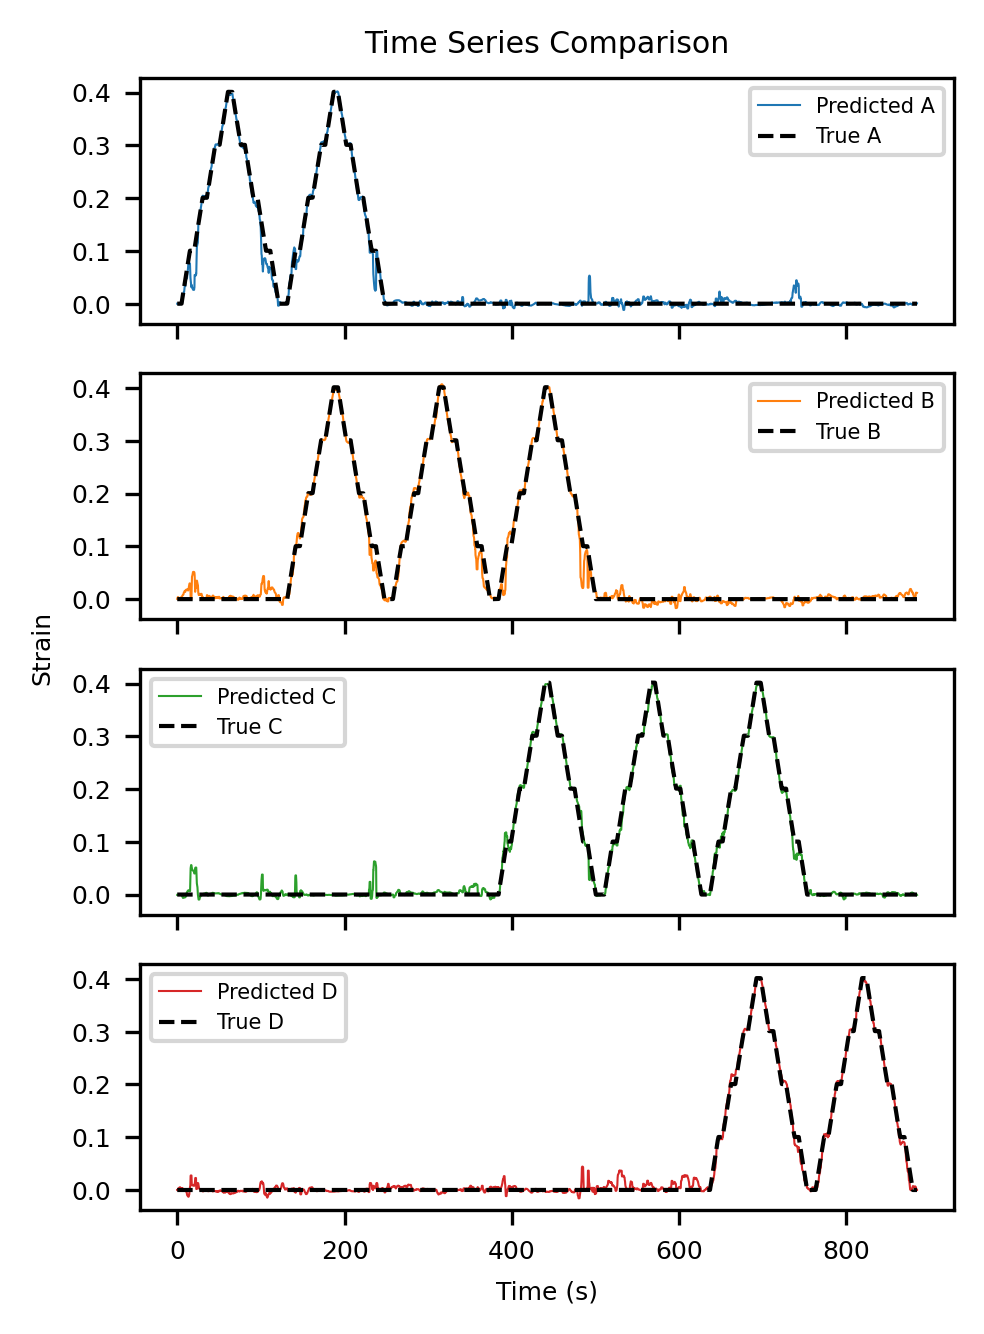

RMSE Train:
A: 0.0074
B: 0.0109
C: 0.0066
D: 0.0077
Avg: 0.0082
RMSE Validation:
A: 0.0100
B: 0.0116
C: 0.0081
D: 0.0079
Avg: 0.0094
RMSE Test:
A: 0.0112
B: 0.0129
C: 0.0093
D: 0.0083
Avg: 0.0104


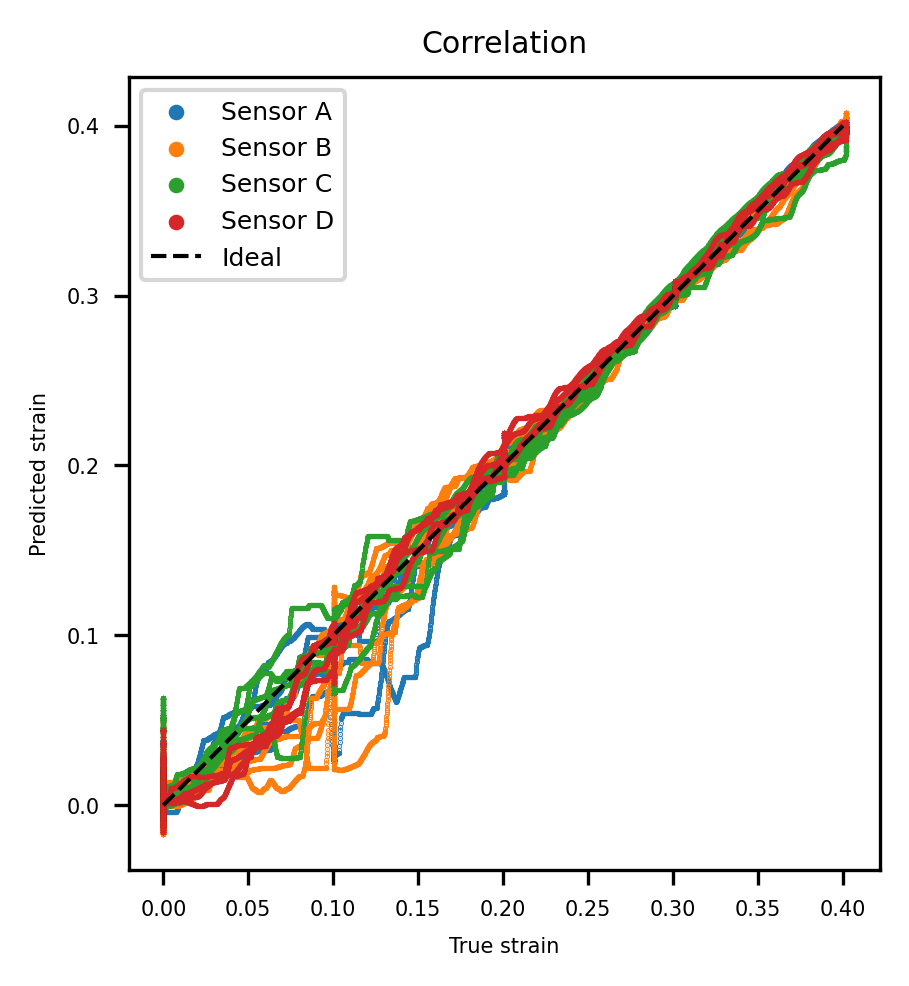

R2 Train:
A: 0.9953
B: 0.9924
C: 0.9972
D: 0.9950
Avg: 0.9950
R2 Validation:
A: 0.9916
B: 0.9913
C: 0.9957
D: 0.9947
Avg: 0.9933
R2 Test:
A: 0.9895
B: 0.9892
C: 0.9945
D: 0.9942
Avg: 0.9918


In [46]:
fs = 100
mlp_best = load_model('mlp/20230127T161506_mlp_763_0.00010_0.00012.hdf5')
fig = plt.figure(figsize=[3.5, 5], dpi=300)
ax = fig.subplots(4, 1, sharex=True, sharey=True)
y_test_pred = mlp_best.predict(x_test, batch_size=128)
t = np.arange(0,len(y_test_pred)/fs, 1/fs)
y_test_pred_medfilt = np.apply_along_axis(lambda x: signal.medfilt(x, kernel_size=201), 0, y_test_pred)
y_train_pred = mlp_best.predict(x_train, batch_size=128)
y_train_pred_medfilt = np.apply_along_axis(lambda x: signal.medfilt(x, kernel_size=201), 0, y_train_pred)
y_val_pred = mlp_best.predict(x_val, batch_size=128)
y_val_pred_medfilt = np.apply_along_axis(lambda x: signal.medfilt(x, kernel_size=201), 0, y_val_pred)

plot_timeseries(ax, t, y_test, y_test_pred_medfilt, title='Time Series Comparison', filename='timeseries.png')
plt.show()

print("RMSE Train:")
print('\n'.join(y + ": " + "{:.4f}".format(x) for x, y in zip(mean_squared_error(y_train, y_train_pred_medfilt, multioutput='raw_values', squared=False), ['A', 'B', 'C', 'D'])))
print("Avg: " + "{:.4f}".format(mean_squared_error(y_train, y_train_pred_medfilt, squared=False)))
print("RMSE Validation:")
print('\n'.join(y + ": " + "{:.4f}".format(x) for x, y in zip(mean_squared_error(y_val, y_val_pred_medfilt, multioutput='raw_values', squared=False), ['A', 'B', 'C', 'D'])))
print("Avg: " + "{:.4f}".format(mean_squared_error(y_val, y_val_pred_medfilt, squared=False)))
print("RMSE Test:")
print('\n'.join(y + ": " + "{:.4f}".format(x) for x, y in zip(mean_squared_error(y_test, y_test_pred_medfilt, multioutput='raw_values', squared=False), ['A', 'B', 'C', 'D'])))
print("Avg: " + "{:.4f}".format(mean_squared_error(y_test, y_test_pred_medfilt, squared=False)))

fig = plt.figure(figsize=[3.5, 3.5], dpi=300)
ax = plt.gca()
plot_correlation(ax, y_test, y_test_pred_medfilt, title='Correlation', filename='correlation.png')
plt.show()

print("R2 Train:")
print('\n'.join(y + ": " + "{:.4f}".format(x) for x, y in zip(r2_score(y_train, y_train_pred_medfilt, multioutput='raw_values'), ['A', 'B', 'C', 'D'])))
print("Avg: " + "{:.4f}".format(r2_score(y_train, y_train_pred_medfilt)))
print("R2 Validation:")
print('\n'.join(y + ": " + "{:.4f}".format(x) for x, y in zip(r2_score(y_val, y_val_pred_medfilt, multioutput='raw_values'), ['A', 'B', 'C', 'D'])))
print("Avg: " + "{:.4f}".format(r2_score(y_val, y_val_pred_medfilt)))
print("R2 Test:")
print('\n'.join(y + ": " + "{:.4f}".format(x) for x, y in zip(r2_score(y_test, y_test_pred_medfilt, multioutput='raw_values'), ['A', 'B', 'C', 'D'])))
print("Avg: " + "{:.4f}".format(r2_score(y_test, y_test_pred_medfilt)))

In [12]:
y_pred_all = np.zeros((len(iq_data), y_test_pred.shape[1]))
y_pred_all[is_train,:] = y_train_pred_medfilt
y_pred_all[is_val,:] = y_val_pred_medfilt
y_pred_all[is_test,:] = y_test_pred_medfilt

692/692 [==============================] - 1s 791us/step


In [15]:
y_pred_df = pd.DataFrame(y_pred_all, columns=[x[0] + '_pred' for x in y_test.columns])
labels_df = pd.DataFrame(np.column_stack((is_multi, is_train, is_val, is_test)), columns=['is_multi', 'is_train', 'is_val', 'is_test'])
iq_data.columns = ['_'.join(filter(None, [x[0].strip(), str(x[1]).strip()])) for x in iq_data.columns] 
mlp_data = pd.concat((iq_data, y_pred_df, labels_df), axis=1)
mlp_data.head()

,trial,sensor,time,strain,I_12451,I_24902,I_49805,I_99609,Q_12451,Q_24902,...,strain_C,strain_D,strain_A_pred,strain_B_pred,strain_C_pred,strain_D_pred,is_multi,is_train,is_val,is_test
0,0,A,0.00,0.000000,61.735968,51.582492,-0.609893,1.306422,9.670989,-14.778372,...,0.0,0.0,0.000008,0.0,-0.004250,0.000833,False,True,False,False
1,0,A,0.01,0.000002,60.924998,51.307946,-0.309325,1.306422,9.376489,-15.124890,...,0.0,0.0,0.000010,0.0,-0.004251,0.000833,False,True,False,False
2,0,A,0.02,0.000004,60.114029,51.032348,-0.007606,1.306422,9.070209,-15.471408,...,0.0,0.0,0.000011,0.0,-0.004256,0.000833,False,True,False,False
3,0,A,0.03,0.000007,59.304094,50.757802,0.292962,1.306422,8.775709,-15.805092,...,0.0,0.0,0.000016,0.0,-0.004258,0.000833,False,True,False,False
4,0,A,0.04,0.000011,58.493124,50.483257,0.593529,1.306422,8.469429,-16.151610,...,0.0,0.0,0.000020,0.0,-0.004270,0.000833,False,True,False,False


In [78]:
y = mlp_data[['strain_A', 'strain_B', 'strain_C', 'strain_D']]
y_pred = mlp_data[['strain_A_pred', 'strain_B_pred', 'strain_C_pred', 'strain_D_pred']]

print("RMSE All:")
print('\n'.join(y + ": " + "{:.4f}".format(x) for x, y in zip(mean_squared_error(y, y_pred, multioutput='raw_values', squared=False), ['A', 'B', 'C', 'D'])))
print("Avg: " + "{:.4f}".format(mean_squared_error(y, y_pred, squared=False)))
print('\n')
print("R2 All:")
print('\n'.join(y + ": " + "{:.4f}".format(x) for x, y in zip(r2_score(y, y_pred, multioutput='raw_values'), ['A', 'B', 'C', 'D'])))
print("Avg: " + "{:.4f}".format(r2_score(y, y_pred)))

RMSE All:
A: 0.0086
B: 0.0114
C: 0.0074
D: 0.0079
Avg: 0.0088


R2 All:
A: 0.9937
B: 0.9917
C: 0.9965
D: 0.9948
Avg: 0.9942


In [75]:
y_train_multi = mlp_data[['strain_A', 'strain_B', 'strain_C', 'strain_D']].loc[mlp_data.is_multi & mlp_data.is_train]
y_train_pred_multi = mlp_data[['strain_A_pred', 'strain_B_pred', 'strain_C_pred', 'strain_D_pred']].loc[mlp_data.is_multi & mlp_data.is_train]
y_val_multi = mlp_data[['strain_A', 'strain_B', 'strain_C', 'strain_D']].loc[mlp_data.is_multi & mlp_data.is_val]
y_val_pred_multi = mlp_data[['strain_A_pred', 'strain_B_pred', 'strain_C_pred', 'strain_D_pred']].loc[mlp_data.is_multi & mlp_data.is_val]
y_test_multi = mlp_data[['strain_A', 'strain_B', 'strain_C', 'strain_D']].loc[mlp_data.is_multi & mlp_data.is_test]
y_test_pred_multi = mlp_data[['strain_A_pred', 'strain_B_pred', 'strain_C_pred', 'strain_D_pred']].loc[mlp_data.is_multi & mlp_data.is_test]
y_train_single = mlp_data[['strain_A', 'strain_B', 'strain_C', 'strain_D']].loc[~mlp_data.is_multi & mlp_data.is_train]
y_train_pred_single = mlp_data[['strain_A_pred', 'strain_B_pred', 'strain_C_pred', 'strain_D_pred']].loc[~mlp_data.is_multi & mlp_data.is_train]
y_val_single = mlp_data[['strain_A', 'strain_B', 'strain_C', 'strain_D']].loc[~mlp_data.is_multi & mlp_data.is_val]
y_val_pred_single = mlp_data[['strain_A_pred', 'strain_B_pred', 'strain_C_pred', 'strain_D_pred']].loc[~mlp_data.is_multi & mlp_data.is_val]
y_test_single = mlp_data[['strain_A', 'strain_B', 'strain_C', 'strain_D']].loc[~mlp_data.is_multi & mlp_data.is_test]
y_test_pred_single = mlp_data[['strain_A_pred', 'strain_B_pred', 'strain_C_pred', 'strain_D_pred']].loc[~mlp_data.is_multi & mlp_data.is_test]

print("RMSE Train:")
print('\n'.join(y + ": " + "{:.4f}".format(x) for x, y in zip([mean_squared_error(y_train_single, y_train_pred_single, squared=False), mean_squared_error(y_train_multi, y_train_pred_multi, squared=False)], ['Single', 'Double'])))
print("RMSE Validation:")
print('\n'.join(y + ": " + "{:.4f}".format(x) for x, y in zip([mean_squared_error(y_val_single, y_val_pred_single, squared=False), mean_squared_error(y_val_multi, y_val_pred_multi, squared=False)], ['Single', 'Double'])))
print("RMSE Test:")
print('\n'.join(y + ": " + "{:.4f}".format(x) for x, y in zip([mean_squared_error(y_test_single, y_test_pred_single, squared=False), mean_squared_error(y_test_multi, y_test_pred_multi, squared=False)], ['Single', 'Double'])))
print('\n')
print("R2 Train:")
print('\n'.join(y + ": " + "{:.4f}".format(x) for x, y in zip([r2_score(y_train_single, y_train_pred_single), r2_score(y_train_multi, y_train_pred_multi)], ['Single', 'Double'])))
print("R2 Validation:")
print('\n'.join(y + ": " + "{:.4f}".format(x) for x, y in zip([r2_score(y_val_single, y_val_pred_single), r2_score(y_val_multi, y_val_pred_multi)], ['Single', 'Double'])))
print("R2 Test:")
print('\n'.join(y + ": " + "{:.4f}".format(x) for x, y in zip([r2_score(y_test_single, y_test_pred_single), r2_score(y_test_multi, y_test_pred_multi)], ['Single', 'Double'])))

RMSE Train:
Single: 0.0059
Double: 0.0104
RMSE Validation:
Single: 0.0082
Double: 0.0107
RMSE Test:
Single: 0.0101
Double: 0.0108


R2 Train:
Single: 0.9965
Double: 0.9929
R2 Validation:
Single: 0.9936
Double: 0.9924
R2 Test:
Single: 0.9903
Double: 0.9924


In [80]:
y_multi = mlp_data[['strain_A', 'strain_B', 'strain_C', 'strain_D']].loc[mlp_data.is_multi]
y_pred_multi = mlp_data[['strain_A_pred', 'strain_B_pred', 'strain_C_pred', 'strain_D_pred']].loc[mlp_data.is_multi]
y_single = mlp_data[['strain_A', 'strain_B', 'strain_C', 'strain_D']].loc[~mlp_data.is_multi]
y_pred_single = mlp_data[['strain_A_pred', 'strain_B_pred', 'strain_C_pred', 'strain_D_pred']].loc[~mlp_data.is_multi]

print("RMSE All:")
print('\n'.join(y + ": " + "{:.4f}".format(x) for x, y in zip([mean_squared_error(y_single, y_pred_single, squared=False), mean_squared_error(y_multi, y_pred_multi, squared=False)], ['Single', 'Double'])))
print("R2 All:")
print('\n'.join(y + ": " + "{:.4f}".format(x) for x, y in zip([r2_score(y_single, y_pred_single), r2_score(y_multi, y_pred_multi)], ['Single', 'Double'])))

RMSE All:
Single: 0.0072
Double: 0.0105
R2 All:
Single: 0.9949
Double: 0.9928


In [16]:
mlp_data.to_csv(datetime.strftime(datetime.now(), '%Y%m%dT%H%M%S_StrainPrediction.csv'))